In [1]:
import pandas as pd
df=pd.read_csv('election data.csv') # read the scraped data
major_parties = ['LP', 'APC', 'NNPP', 'PDP'] #create a list for the major parties
other_parties = [col for col in df.columns if col not in major_parties and col not in ['State', 'Total Votes', 'Registered Voters']]#get other parties
parties = major_parties + ['Others']#have a reference for all the parties
df['Others'] = df[other_parties].sum(axis=1)#join all the other parties into others
df.drop(columns=other_parties, inplace=True)#remove those other parties to reduce the amount of columns and repitition
df['Voters Turnout(%)'] = df['Total Votes']*100/df['Registered Voters']#calculate the turnout of voters in percentage(%)
df['Winner'] = df[['LP', 'NNPP', 'PDP', 'APC']].idxmax(axis=1)#get the winner for each state
df.State=df.State.str.replace('Federal Capital Territory','FCT')#rename Federal Capital Territory to FCT to shorten it

In [2]:
#create a dictionary zone putting state in there zones, this was searched up online
zone={
    'north_central':['Benue','Kogi','Kwara','Nasarawa','Niger','Plateau','FCT'],
    'north_east': ['Adamawa','Bauchi','Borno','Gombe','Taraba','Yobe'],
    'north_west': ['Jigawa','Kaduna','Kano','Katsina','Kebbi','Sokoto','Zamfara'],
    'south_east': ['Abia','Anambra','Ebonyi','Enugu','Imo'],
    'south_south':['Akwa Ibom','Bayelsa','Cross River','Delta','Edo','Rivers'],
    'south_west':['Ekiti','Lagos','Ogun','Ondo','Osun','Oyo']
}


#function to sort states putting them in zones using short notation NC, NE, NW, SE, SS, SW
def sort_by_zone(state):
    if state in zone['north_central']:
        return 'NC'
    elif state in zone['north_east']:
        return 'NE'
    elif state in zone['north_west']:
        return 'NW'
    elif state in zone['south_east']:
        return 'SE'
    elif state in zone['south_south']:
        return 'SS'
    elif state in zone['south_west']:
        return 'SW'
    
df['Zone']=df.State.apply(sort_by_zone)#apply the function on the state and adding it to a new column zone
df['Did Not Vote']=df['Registered Voters']-df['Total Votes']#get the numbers of those that did not vote and add them to a new column did not vote

In [3]:
#import needed libraries
import geopandas as gpd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import numpy as np


nigeria_map=gpd.read_file(r"C:\Users\Lenovo\Desktop\datasets\adm1_STATES\NGA_adm1.shp")#read the shapefile of nigeria map(it was downloaded online)
nigeria_map.NAME_1.replace('Nassarawa','Nasarawa', inplace=True)#after viewing, make correction on wrong spelling
nigeria_map.NAME_1.replace('Federal Capital Territory','FCT',inplace=True)#rename Federal Capital Territory to FCT 

In [4]:
merged_df=nigeria_map.merge(df, left_on='NAME_1',right_on='State')#merge the df to the shape file

In [5]:
#function to create numbers for every winner
#to plot, it takes numbers and not string, so create number equivalent for each winner 
def winner2num(winner):
    for i in range(len(merged_df.Winner.unique())):
        if winner==merged_df.Winner.unique()[i]:
            return merged_df.Winner.unique()[i]

merged_df['Winner Party'] = merged_df.Winner.apply(winner2num)#apply the function and put it in a column winner party
merged_df['Winner Party'] = merged_df['Winner Party'].astype('category')#convert it to type category

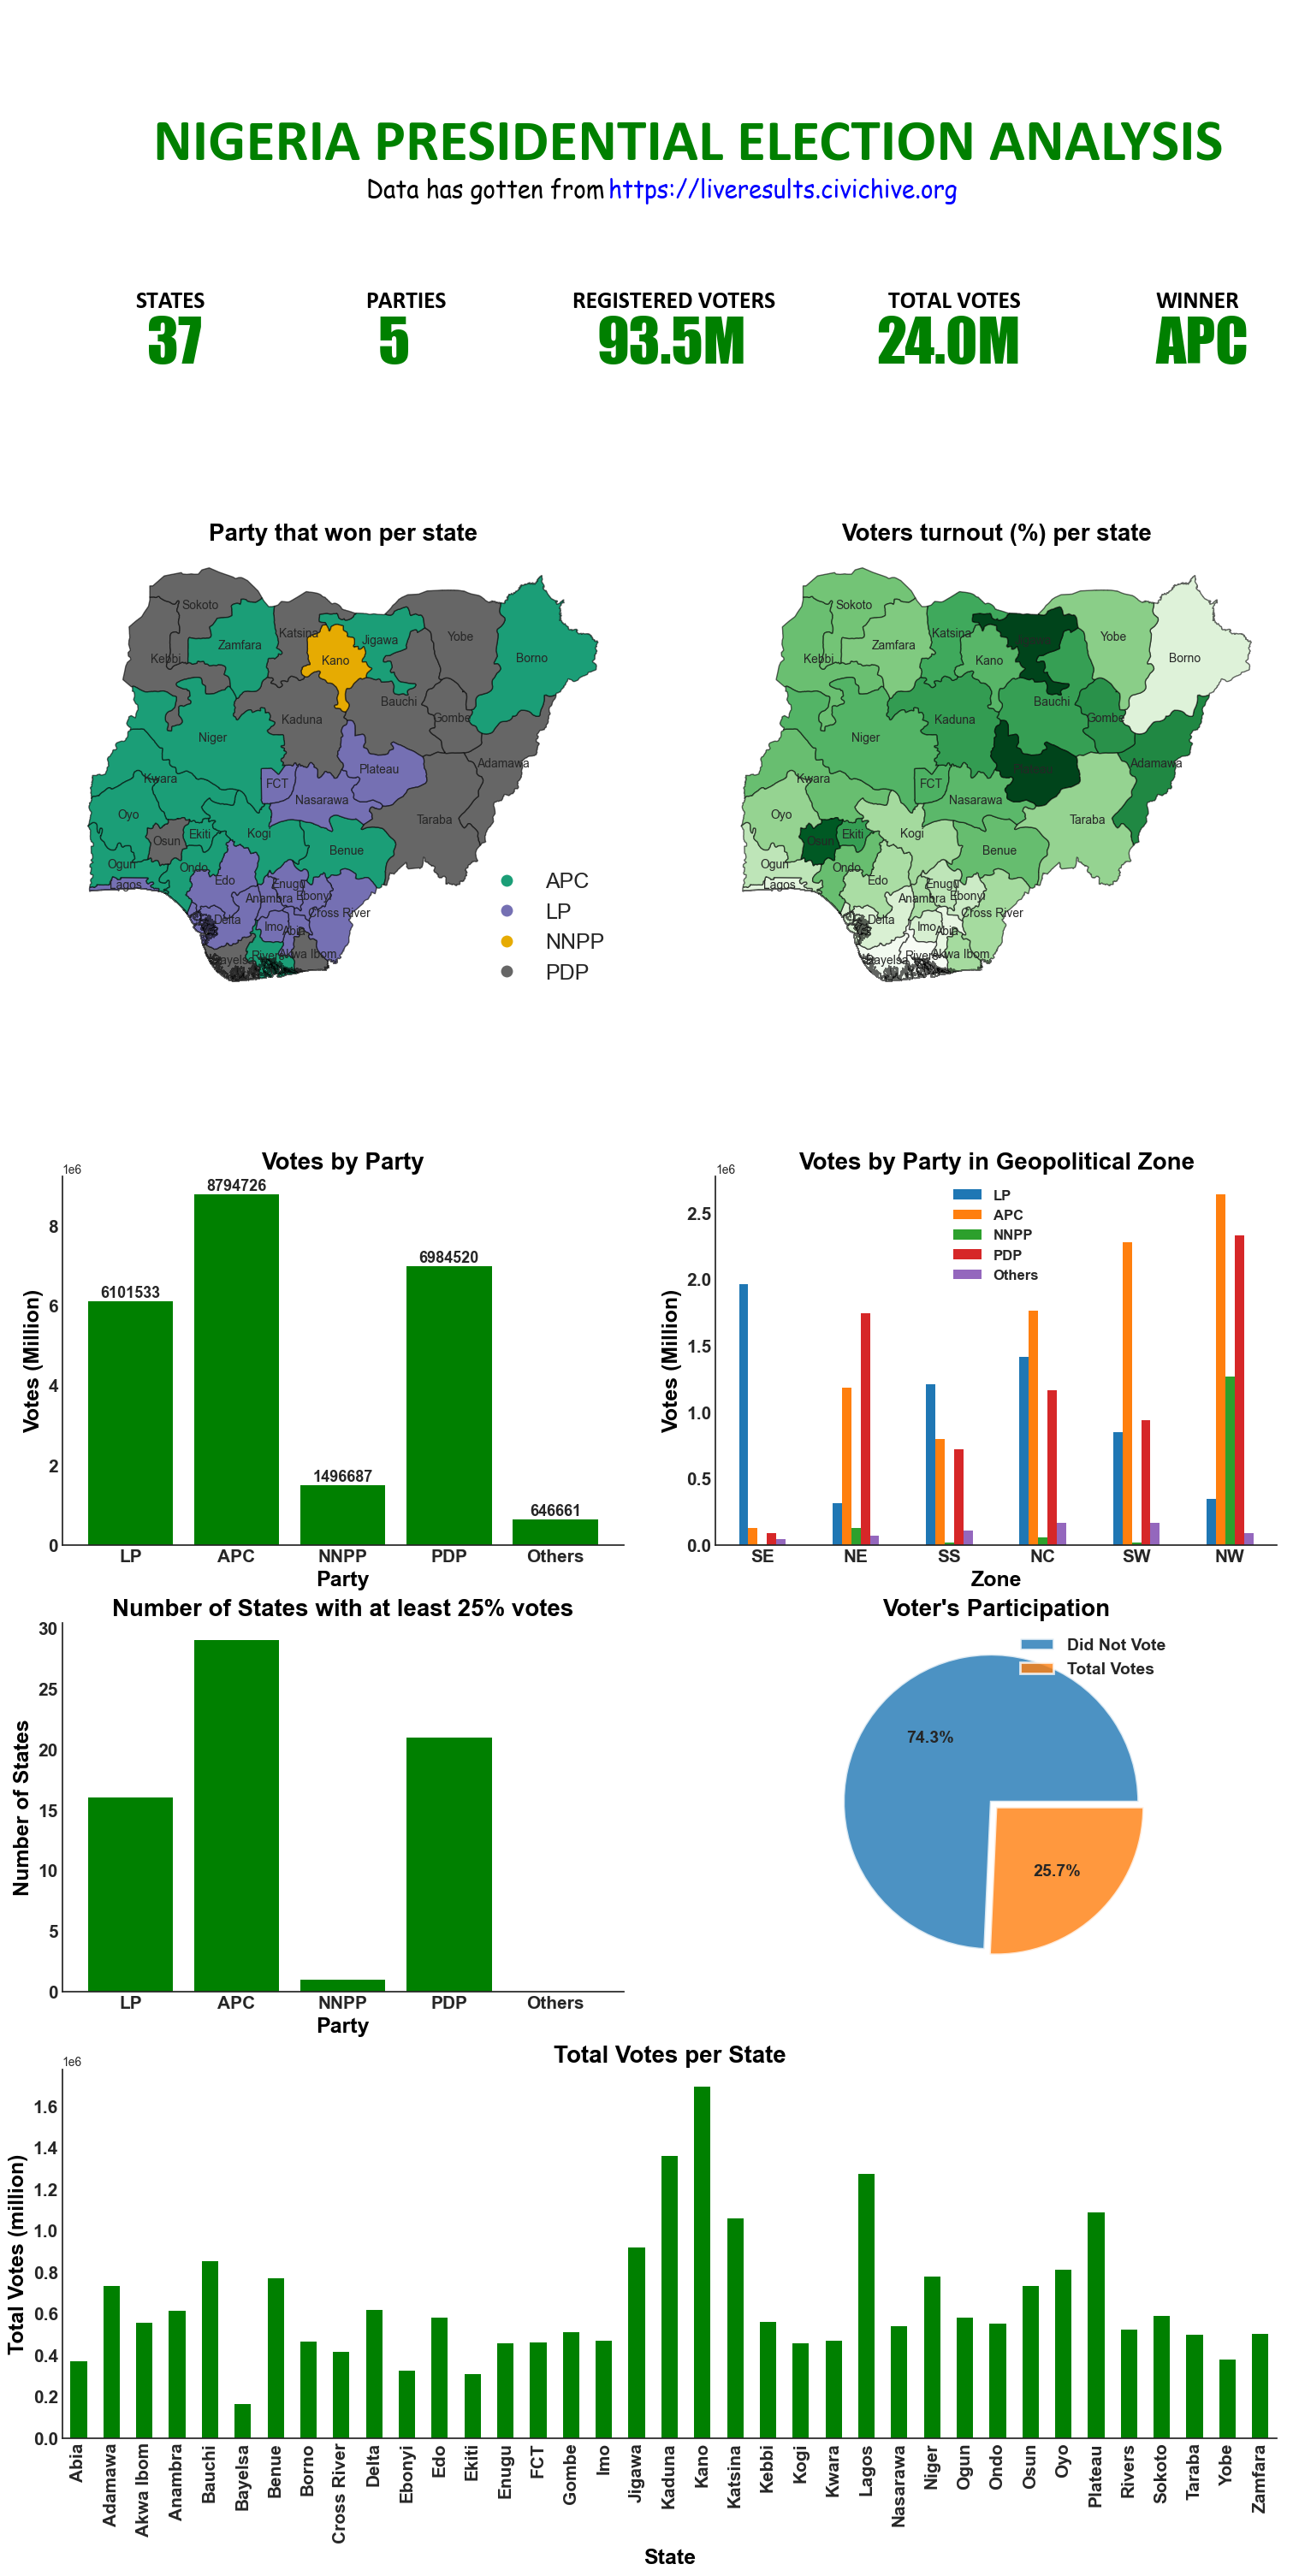

In [6]:
#Configuring the plt.figure()
fig = plt.figure(figsize=(15,30), constrained_layout=True,frameon='green')
spec = fig.add_gridspec(6,2)# 6 rows & 3 cols

#draw a rectangle and place it in first row, all columns
ax0 = fig.add_subplot(spec[0,:])
rec = plt.Rectangle((0,0), height = 5, width = 7, fc = 'white')
fi = plt.gca()
fi.add_patch(rec)

#Hide the ticks and add text to the rectangle
plt.xticks(color='white')
plt.yticks(color='white')
plt.text(0.075,0.6,'NIGERIA PRESIDENTIAL ELECTION ANALYSIS', color = 'green', font ='Calibri', size = 50, weight='bold')
plt.text(0.25,0.5,'Data has gotten from', color = 'black', size=20, font ='cursive' )
plt.text(0.45,0.5,'https://liveresults.civichive.org', color = 'blue', size=20, font ='cursive' )

plt.text(0.06,0.2, f'STATES', font='calibri', size = 20, weight ='bold', color = 'black')
plt.text(0.07,0.05,f'{len(merged_df)}', font='fantasy',size=50,color='green')

plt.text(0.25,0.2, f'PARTIES', font='calibri', size = 20, weight ='bold', color = 'black')
plt.text(0.26,0.05,f'{len(parties)}', font='fantasy',size=50,color='green')

plt.text(0.42,0.2, f'REGISTERED VOTERS', font='calibri', size = 20, weight ='bold', color = 'black')
registered_voters='{:.1f}M'.format(merged_df['Registered Voters'].sum()/1000000) #get registered voters in form 93.5M
plt.text(0.44,0.05,f'{registered_voters}', font='fantasy',size=50,color='green')

total_votes='{:.1f}M'.format(merged_df['Total Votes'].sum()/1000000)#get total votes in the form 24.0M
plt.text(0.68,0.2, f'TOTAL VOTES', font='calibri', size = 20, weight ='bold', color = 'black')
plt.text(0.67,0.05,f'{total_votes}', font='fantasy',size=50,color='green')

winning_party=df[parties].sum().idxmax()#get the party with the overall highest votes(winner)
plt.text(0.90,0.2, f'WINNER', font='calibri', size = 20, weight ='bold', color = 'black')
plt.text(0.90,0.05,f'{winning_party}', font='fantasy',size=50,color='green')

#Remove the border from the rectangle
ax0.spines.top.set_visible(False)
ax0.spines.right.set_visible(False)
ax0.spines.left.set_visible(False)
ax0.spines.bottom.set_visible(False)

#plot choropleth maps making use of row 1 and 2
ax20=fig.add_subplot(spec[1:3,0])#plot for the first column
ax21=fig.add_subplot(spec[1:3,1])#plot for the second column

#choropleth map showing the winning party per state
merged_df.plot(column='Winner Party', edgecolor=(0, 0, 0, 0.6), cmap='Dark2', legend=True, ax=ax20, legend_kwds={'loc': 'lower right', 'fontsize':18})
ax20.set_title('Party that won per state',size=20,fontweight='bold',color='black')
ax20.set_axis_off()


#choropleth map showing voters turnout per state
merged_df.plot(column='Voters Turnout(%)',cmap='Greens',edgecolor=(0,0,0,.6),ax=ax21)
ax21.set_title('Voters turnout (%) per state',size=20,fontweight='bold',color='black')
ax21.set_axis_off()

#loop to put state name on the map
for idx, row in merged_df.iterrows():
    state_name = row['NAME_1']
    centroid = row['geometry'].centroid
    ax20.annotate(text=state_name, xy=(centroid.x, centroid.y), ha='center', va='center', fontsize=10)
    ax21.annotate(text=state_name, xy=(centroid.x, centroid.y), ha='center', va='center', fontsize=10)



#plot for total votes for each party in all states    
ax30=fig.add_subplot(spec[3,0])    
ax30.bar(parties, df[parties].sum(), color='green')
ax30.set_title('Votes by Party',size=20,fontweight='bold',color='black')
ax30.set_xlabel('Party',size=18,fontweight='bold',color='black')
ax30.set_ylabel('Votes (Million)',size=18,fontweight='bold',color='black')
plt.xticks(fontsize=15, fontweight='bold')
plt.yticks(fontsize=15, fontweight='bold')

ax30.spines.top.set_visible(False)
ax30.spines.right.set_visible(False)

# Add the vote counts to each bar
for i, v in enumerate(df[parties].sum()):
    ax30.text(i, v + 100000, str(v), ha='center', size=13, weight='bold')
    

zone_vote = {}#an empty dictionary to store the votes in each geopolitical zone
#loop going through each zone and getting the votes storing it in the dictionary
for i in df['Zone'].unique():
    zone_vote[i] = dict(df.where(df.Zone == i).dropna().reset_index().drop('index', axis=1)[parties].sum())

zone_df = pd.DataFrame(zone_vote).transpose()#from the zone_vote, create a dataframe and transpose to change the structure

#plot for Votes in each geopolitical zone
ax31=fig.add_subplot(spec[3,1])
zone_df.plot(kind='bar', ax=ax31, rot=0)
ax31.set_title('Votes by Party in Geopolitical Zone',size=20,fontweight='bold',color='black')
ax31.set_xlabel('Zone',size=18,fontweight='bold',color='black')
ax31.set_ylabel('Votes (Million)',size=18,fontweight='bold',color='black')
plt.xticks(fontsize=15, fontweight='bold')
plt.yticks(fontsize=15, fontweight='bold')

ax31.legend(prop={'size':12, 'weight':'bold'})

ax31.spines.top.set_visible(False)
ax31.spines.right.set_visible(False)


# calculate the number of states where each party received at least 25% of the votes
min_percent = {party: len(df.where(df[party] >= df['Total Votes'] / 4).dropna().reset_index().drop('index', axis=1)) for party in parties}

# creates a bar chart with the number of states where each party received at least 25% of the votes
ax40=fig.add_subplot(spec[4,0])
ax40.bar(min_percent.keys(), min_percent.values(), color='green')
ax40.set_title('Number of States with at least 25% votes',size=20,fontweight='bold',color='black')
ax40.set_xlabel('Party',size=18,fontweight='bold',color='black')
ax40.set_ylabel('Number of States',size=18,fontweight='bold',color='black')
plt.xticks(fontsize=15, fontweight='bold')
plt.yticks(fontsize=15, fontweight='bold')

ax40.spines.top.set_visible(False)
ax40.spines.right.set_visible(False)

ax41=fig.add_subplot(spec[4,1])


#create a dataframe for sum of those that voted and those that didnt vote
votes_df = df[['Did Not Vote', 'Total Votes']].sum().to_frame().T
# create a pie chart with the total number of voters that didnt vote and total votes
wedgeprops = {'linewidth': 2, 'edgecolor': 'white', 'alpha': 0.8}
ax41.pie(votes_df.values[0], autopct='%1.1f%%', wedgeprops=wedgeprops, explode=(0.05, 0), textprops={'fontsize':14, 'fontweight':'bold'})
ax41.set_title('Voter\'s Participation',size=20,fontweight='bold',color='black')
ax41.legend(votes_df.columns, prop={'size':14, 'weight':'bold'})


#plot showing votes of each state
ax50 = fig.add_subplot(spec[5,:])
df[['State', 'Total Votes']].plot(x='State', kind='bar', ax=ax50, color='green', legend=False)
ax50.set_title('Total Votes per State',size=20,fontweight='bold', color='black')
ax50.set_xlabel('State',size=18,fontweight='bold',color='black')
ax50.set_ylabel('Total Votes (million)',size=18,fontweight='bold',color='black')
plt.xticks(fontsize=15, fontweight='bold')
plt.yticks(fontsize=15, fontweight='bold')

ax50.spines.top.set_visible(False)
ax50.spines.right.set_visible(False)



plt.savefig('dashboard.png', bbox_inches='tight')#save the plot

plt.show()


